In [1]:
import re
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from sklearn.neighbors import KNeighborsClassifier

# Get data

In [2]:
# dataset_filename = "all_sentences_processed.csv"
# df = pd.read_csv(dataset_filename, encoding='utf8', index_col=False).drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

dataset_filename = "input.csv"
df = pd.read_csv(dataset_filename, encoding='utf8', index_col=False).drop('Unnamed: 0', axis=1)

In [3]:
# no null values 
df.isnull().sum()

text           0
label          0
source_file    0
scenario       0
dtype: int64

<Axes: xlabel='label', ylabel='count'>

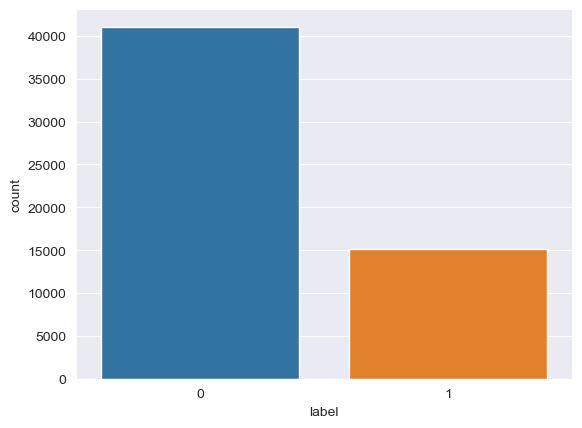

In [4]:
# A bit unbalanced
sns.countplot(x="label",data=df)

# EXTRA PREPROCESSING

In [5]:
# # 1:1 ratio
# df1 = df[df.label==0].sample(n=len(df[df.label==1])).reset_index(drop=True)
# df2 = df[df.label==1]
# df = pd.concat([df1, df2], ignore_index=True)
# sns.countplot(x="label",data=df)

In [6]:
# input_df = pd.DataFrame({"text": list(df['preprocessed_text']), "label": list(df['label']), "source_file": list(df["source_file"]), "scenario": list(df["scenario"])})

In [7]:
# remove trailing whitespaces and lowercase, remove commas with space before them
# input_df['text'] = [x.lstrip().rstrip().lower().replace("[]", "").replace("]", "") for x in input_df['text']]

# input_df['text'] = [re.sub(' +|\t', ' ', x) for x in input_df['text']]

# input_df['text'] = [re.sub(' ,', '', x) for x in input_df['text']]

In [8]:
# input_df    

In [9]:
# input_df.to_csv("input.csv")

In [10]:
input_df = df

# Encoding # 1

In [11]:
import multiprocessing
from gensim.models import Word2Vec

In [12]:
cores = multiprocessing.cpu_count()
cores

16

In [13]:
# words_in_sentences=[]
# for i in input_df["text"]:
#     words_in_sentences.append(i.lower().split())
# words_in_sentences[0]

['how', 'i', 'feel', 'with', 'my', 'speech.']

In [14]:
# input_df.iloc[0]

text           how i feel with my speech.
label                                   1
source_file                kurland24a.cha
scenario                           Speech
Name: 0, dtype: object

In [15]:
# w2v_model = Word2Vec(min_count=1,
#                      window=2,
#                      vector_size = 300,
#                      sample=6e-5, 
#                      alpha=0.03, 
#                      min_alpha=0.0007, 
#                      negative=20,
#                      workers=cores-1)

In [16]:
# w2v_model.build_vocab(words_in_sentences, progress_per=10000)

In [17]:
# w2v_model.train(words_in_sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(4214577, 13084080)

In [44]:
# w2v_model.save("word2vec_knn.model")

In [45]:
w2v_model = Word2Vec.load("word2vec_knn.model")

In [46]:
vocab=list(w2v_model.wv.key_to_index.keys())
print(len(vocab))

14716


In [19]:
def avg_w2vec(sentences, labels):
    """
    Average Word2Vec approach for creating a vector for a given sentence from the word embeddings of each words of the sentence.
    """

    transformed=[]
    lab = []
    for sentence, label in zip(sentences,labels):
        count=0
        vector=np.zeros(300)
        for word in sentence.split():
            if word in vocab:
                vector+=w2v_model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
            lab.append(label)
    return np.array(transformed), np.array(lab)

In [20]:
transformed_text, labels1= avg_w2vec(input_df["text"], input_df["label"])

# Model fitting

In [21]:
# train test split
x_train,x_test, y_train, y_test = train_test_split(transformed_text, labels1, stratify=labels1, test_size=0.20, random_state=42)

In [22]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import f1_score
# # odd k for preventing ties
grid_params = { 'n_neighbors' : [3, 5, 7, 9, 11],
               'metric' : ['manhattan', 'minkowski', 'cosine']}

In [23]:
# knn=KNeighborsClassifier()
# clf = GridSearchCV(knn, grid_params, n_jobs=10, verbose=1, return_train_score=True)
# clf.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=10,
             param_grid={'metric': ['manhattan', 'minkowski', 'cosine'],
                         'n_neighbors': [3, 5, 7, 9, 11]},
             return_train_score=True, verbose=1)

In [24]:
# clf.best_params_

{'metric': 'manhattan', 'n_neighbors': 5}

In [25]:
# clf.cv_results_ 

{'mean_fit_time': array([0.09990849, 0.09926376, 0.07822366, 0.06881723, 0.07601061,
        0.08317432, 0.075035  , 0.07138062, 0.06310101, 0.06550713,
        0.0944375 , 0.08084383, 0.07925563, 0.07623401, 0.11623826]),
 'std_fit_time': array([0.0056599 , 0.00518859, 0.00018679, 0.00912313, 0.00399323,
        0.00401539, 0.00629641, 0.00588451, 0.00043967, 0.00631089,
        0.03324101, 0.01109938, 0.02424437, 0.01090461, 0.02878864]),
 'mean_score_time': array([ 67.49214525,  67.46120048,  68.64143243,  68.60285978,
         73.69819994,   7.27064691,   6.1362833 ,   6.07756534,
          6.1607811 ,   6.10292611,  27.26745148,  11.36632276,
         10.7553544 ,  11.32101159, 131.94647918]),
 'std_score_time': array([0.03594673, 0.08572168, 0.09097211, 0.13528967, 0.09721084,
        0.09006543, 0.08202467, 0.10745636, 0.05845002, 0.11895544,
        0.56968047, 0.3574757 , 0.21492062, 0.15360341, 7.01414602]),
 'param_metric': masked_array(data=['manhattan', 'manhattan', 'manha

In [26]:
# result_df = pd.concat([pd.DataFrame(clf.cv_results_["params"]),
#                        pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["mean_test_acc"]),
#                        pd.DataFrame(clf.cv_results_["mean_train_score"], columns=["mean_train_acc"]),
#                        pd.DataFrame(clf.cv_results_["std_train_score"], columns=["std_train_acc"]),
#                        pd.DataFrame(clf.cv_results_["std_test_score"], columns=["std_test_acc"])], axis=1)

In [27]:
# result_df.to_csv("knn-results.csv")

In [28]:
# knn = KNeighborsClassifier(n_neighbors=clf.best_params_['n_neighbors'], metric=clf.best_params_['metric'])
# knn.fit(x_train, y_train)

KNeighborsClassifier(metric='manhattan')

In [29]:
# knnPickle = open('knn_pickle', 'wb')
# pickle.dump(knn, knnPickle)
# knnPickle.close()

# Training + testing plots

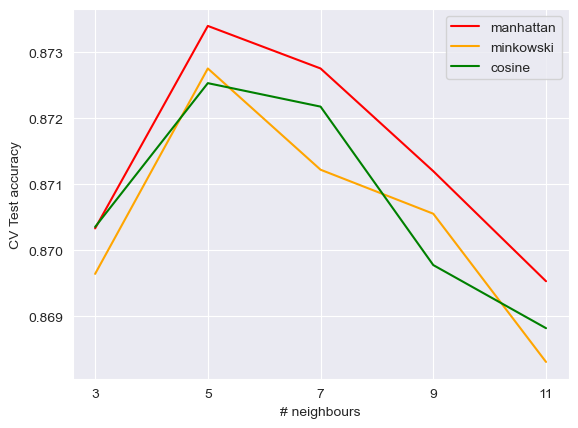

In [30]:
import matplotlib.pyplot as plt

result_df = pd.read_csv("knn-results.csv", encoding="utf-8")
cols = ['red', 'orange', 'green']
for metric, col in zip(grid_params['metric'], cols):
    plt.plot(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_test_acc, color=col, label=metric)

plt.xlabel("# neighbours")
plt.ylabel("CV Test accuracy")
plt.xticks(grid_params['n_neighbors'])
plt.legend()
plt.show()

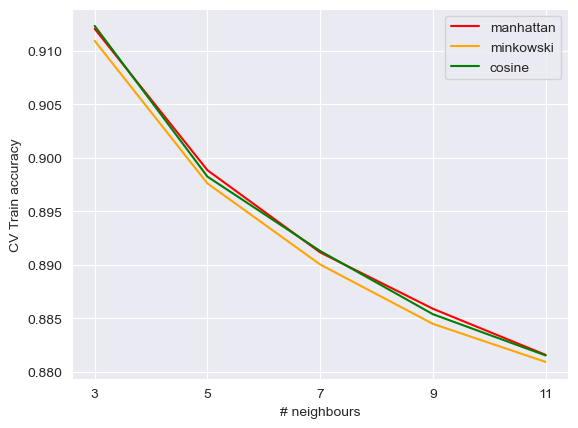

In [42]:
for metric, col in zip(grid_params['metric'], cols):
    plt.plot(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_train_acc, color=col, label=metric)
    # plt.fill_between(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_train_acc - result_df[result_df.metric == metric].std_train_acc,result_df[result_df.metric == metric].mean_train_acc + result_df[result_df.metric == metric].std_train_acc)

plt.xlabel("# neighbours")
plt.ylabel("CV Train accuracy")
plt.xticks(grid_params['n_neighbors'])
plt.legend()
plt.show()

# Evaluation

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [48]:
loaded_model = pickle.load(open('knn_pickle', 'rb'))

In [49]:
result = loaded_model.predict(x_test)

In [35]:
len(x_test)

11254

In [36]:
len(y_test)

11254

In [37]:
print(accuracy_score(y_test, result))

0.88030922338724


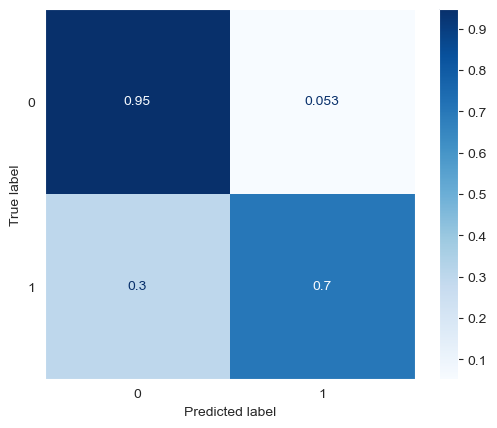

In [38]:
cm = confusion_matrix(y_test, result, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_estimator(loaded_model, x_test,y_test, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [39]:
print(tn, fn, tp, fp)

0.946926354230067 0.2997696610727213 0.7002303389272787 0.05307364576993305


In [40]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)

0.9295455130357955
0.7002303389272787
0.7987552016522742


# Classification on other sentences

In [43]:
# Sentence from prompt engineering
inputs1 = "uh, see, um, blue car. fast, uh, on road."

# Sentence from (ongoing) linguistic model
inputs2= "oh I want ah er apple ah"

# Sentence from C4
inputs3= "Embrace world class facilities at East Bourne Resort & Spa Shimla"

# Sentence from C4
inputs4= "uh and then she ran"

input = [inputs1, inputs2, inputs3, inputs4]
label = [1, 1, 0, 0]
transformed_text, labels = avg_w2vec(input, label)

print(loaded_model.predict(transformed_text))

[1 1 1 0]


# Feature extraction